## Model

In [1]:
using Revise, ReachabilityAnalysis, SparseArrays, Plots
const RA = ReachabilityAnalysis

LazySets.set_ztol(Float64, 1e-14)

#using Polyhedra
#using LazySets: HalfSpace
#using BenchmarkTools
#using LaTeXStrings #, Latexify 
#using Plots, Plots.PlotMeasures

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1260


1.0e-14

In [2]:
function gearbox(; X0 = Hyperrectangle([0., 0., -0.0167, 0.003,  0., 0.],
                                       [0., 0.,  0.0001, 0.0001, 0., 0.]),
                   init = [(1, X0)])

    # variables
    vx = 1  # x velocity
    vy = 2  # y velocity
    px = 3  # x position
    py = 4  # y position
    I = 5   # accumulated impulse
    t = 6   # time

    # number of variables
    n = 5 + 1

    # constants
    Fs = 70.0  # shifting force on the sleeve [N]
    Tf = 1.0  # resisting moments on the second gear [N⋅m]
    # TODO where do the following values come from?
    ms = 3.2  # mass of the sleeve
    Rs = 0.08  # radius of the sleeve
    Jg₂ = 0.7  # inertia of the second gear
    Δp = -0.003  # horizontal (px) distance
    θ = 0.628318530717959  # included angle of the second gear [°]
    mg₂ = 18.1  # mass of the second gear
    ζ = 0.9  # coefficient of restitution

    # discrete structure (graph)
    automaton = LightAutomaton(2)
    add_transition!(automaton, 1, 1, 1)
    add_transition!(automaton, 1, 1, 2)
    add_transition!(automaton, 1, 2, 3)

    # mode 1 ("free")
    A = zeros(n, n)
    b = zeros(n)
    A[px, vx] = 1.
    A[py, vy] = 1.
    b[vx] = Fs / ms
    b[vy] = - (Rs * Tf) / Jg₂
    b[t] = 1.
    invariant = HalfSpace(sparsevec([px], [1.], n), Δp)  # px <= Δp
    # TODO The SpaceEx model adds more constraints, possibly to help with the
    # guard intersection:
    invariant = HPolyhedron([invariant,
        HalfSpace(sparsevec([px, py], [tan(θ), 1.], n), 0.),    # py <= -px * tan(θ)
        HalfSpace(sparsevec([px, py], [tan(θ), -1.], n), 0.)])  # py >= px * tan(θ)
    m_1 = @system(x' = Ax + b, x ∈ invariant)

    # mode 2 ("meshed")
    A = zeros(n, n)
    b = zeros(n)
    b[t] = 1.
    invariant = Universe(n)
    m_2 = @system(x' = Ax + b, x ∈ invariant)

    # common assignment matrix (requires individual modifications)
    A_template = zeros(n, n)
    for i in 3:6
        A_template[i, i] = 1.
    end
    denominator = ms * cos(θ)^2 + mg₂ * sin(θ)^2
    A_template[vx, vx] = (ms * cos(θ)^2 - mg₂ * ζ * sin(θ)^2) / denominator
    A_template[vx, vy] = (-(ζ + 1.) * mg₂ * sin(θ) * cos(θ)) / denominator
    A_template[vy, vx] = (-(ζ + 1.) * ms * sin(θ) * cos(θ)) / denominator
    A_template[vy, vy] = (mg₂ * sin(θ)^2 - ms * ζ * cos(θ)^2) / denominator
    A_template[I, vx] = ((ζ + 1.) * ms * mg₂ * sin(θ)) / denominator
    A_template[I, vy] = ((ζ + 1.) * ms * mg₂ * cos(θ)) / denominator

    # transition l1 -> l1
    # TODO what happened to the term '2nb' and the whole second constraint in the paper?
    guard = HPolyhedron([
        HalfSpace(sparsevec([px, py], [-tan(θ), -1.], n), 0.),     # py >= -px * tan(θ)
        HalfSpace(sparsevec([vx, vy], [-sin(θ), -cos(θ)], n), 0.)  # vx * sin(θ) + vy * cos(θ) >= 0
        ])
    A = copy(A_template)
    t1 = ConstrainedLinearMap(A, guard)

    # transition l1 -> l1
    # TODO same remark as with the other guard
    guard = HPolyhedron([
        HalfSpace(sparsevec([px, py], [-tan(θ), 1.], n), 0.),     # py <= px * tan(θ)
        HalfSpace(sparsevec([vx, vy], [-sin(θ), cos(θ)], n), 0.)  # vx * sin(θ) - vy * cos(θ) >= 0
        ])
    A = copy(A_template)
    A[vx, vy] *= -1.
    A[vy, vx] *= -1.
    A[I, vy] *= -1.
    t2 = ConstrainedLinearMap(A, guard)

    # transition l1 -> l2
    guard = HalfSpace(sparsevec([px], [-1.], n), -Δp)  # px >= Δp - ε
    A = copy(A_template)
    A[vx, vx] = 0.
    A[vx, vy] = 0.
    A[vy, vx] = 0.
    A[vy, vy] = 0.
    A[I, vx] = A[I, vy] = ms
    t3 = ConstrainedLinearMap(A, guard)

    # TODO The SpaceEx model uses four transitions for this one, possibly to
    # help with the signs; note that the assignments are different:
    # * guard = px >= Δp & vx >= 0 & vy >= 0
    #   assignment = I:=I+ms*vx+ms*vy & vx:=0 & vy:=0
    # * guard = px >= Δp & vx >= 0 & vy <= 0
    #   assignment = I:=I+ms*vx-ms*vy & vx:=0 & vy:=0
    # * guard = px >= Δp & vx <= 0 & vy >= 0
    #   assignment = I:=I-ms*vx+ms*vy & vx:=0 & vy:=0
    # * guard = px >= Δp & vx <= 0 & vy <= 0
    #   assignment = I:=I-ms*vx-ms*vy & vx:=0 & vy:=0

    H = HybridSystem(automaton=automaton,
                     modes=[m_1, m_2],
                     resetmaps=[t1, t2, t3])

    return InitialValueProblem(H, init)
end

gearbox (generic function with 1 method)

### Utility functions

In [3]:
function first_empty_intersection(sol, invariant)
    k = 1
    @inbounds for R in sol
        isdisjoint(set(R), invariant) && break
        k += 1
    end
    return k
end

first_empty_intersection (generic function with 1 method)

## Safety properties

The goal is to show that the gears are meshed within a time frame of 0.2 [s] and that the bound
x 5 ≤ 20 [Nm] of the cumulated impulse is met. Using the monitor states free and meshed , and a
global clock t, this can be expressed as a safety property as follows: For all t ≥ 0.2, the monitor
should be in meshed . Under nonblocking assumptions, this means that t < 0.2 whenever the
monitor is not in meshed , i.e., when it is in free.


MES01: forbidden states: (free ∧ t ≥ 0.2) ∨ (x 5 ≥ 20)

In [4]:
#=
# safety property
cond_free = is_contained_in(HalfSpace([0., 0., 0., 0., 0., 1.], 0.2))    # t <= 0.2
cond_global = is_contained_in(HalfSpace([0., 0., 0., 0., 1., 0.], 20.))  # I <= 20
property_free = Conjunction([cond_free, cond_global])
property_meshed = cond_global
property = Dict(1 => property_free, 2 => property_meshed)

# default options
options = Options(:T=>0.5, :property=>property)

return (system, options)
=#

---

## Results

In [5]:
# using Polyhedra, CDDLib

In [7]:
# TODO : fix when using IntervalBox

X0_GRBX01 = (0 .. 0) × (0 .. 0) × (-0.0168 .. -0.0166) × (0.0029 .. 0.0031) × (0 .. 0) × (0 .. 0) # GRBX01
X0_GRBX01 = convert(Hyperrectangle, X0_GRBX01)

X0_GRBX02 = (0 .. 0) × (0 .. 0) × (-0.01675 .. -0.01665) × (0.00285 .. 0.00315) × (0 .. 0) × (0 .. 0) # GRBX02
X0_GRBX02 = convert(Hyperrectangle, X0_GRBX02);

In [8]:
ivp = gearbox(X0=X0_GRBX01);

m1 = mode(system(ivp), 1)
m1_unconstrained = @system(x' = m1.A * x + m1.c)
m1_inv = stateset(m1)

m2 = mode(system(ivp), 2);
m2_unconstrained = @system(x' = m2.A * x + m2.c);
m2_inv = stateset(m2);

In [86]:
alg = LGG09(δ=1e-3, template=OctDirections(6))

sol1 = solve(IVP(m1_unconstrained, X0_GRBX01), tspan=0 .. 0.1, alg=alg);

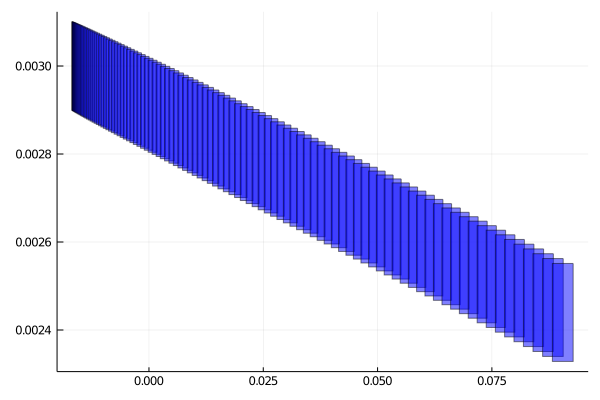

In [78]:
plot([set(Projection(x, [3, 4])) for x in sol1], color=:blue)

Now we need to check if some of the reach-sets in `sol1` have empty intersection with the invariant `m1_inv`.

In [87]:
idx = first_empty_intersection(sol1, m1_inv)
F = Flowpipe(view(sol1.F, 1:(idx - 1)));

In [88]:
length(F)

36

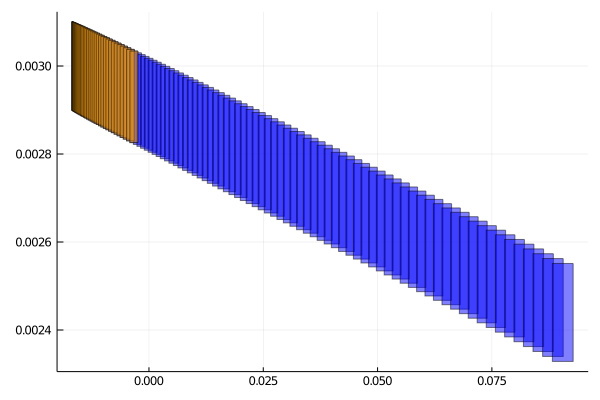

In [79]:
plot!([set(Projection(x, [3, 4])) for x in F], color=:orange)

In [93]:
alg = LGG09(δ=1e-3, template=OctDirections(6))

sol1 = solve(IVP(m1, X0_GRBX01), tspan=0 .. 0.1, alg=alg);

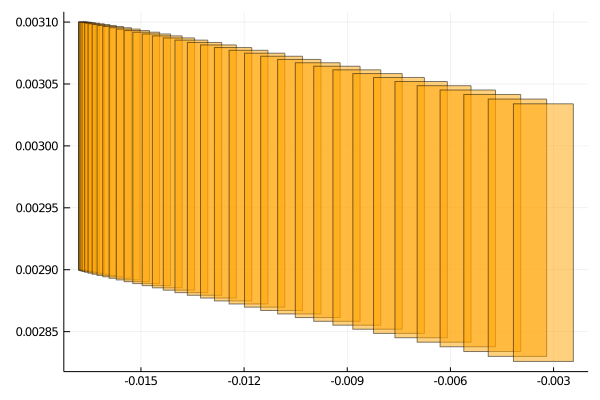

In [95]:
plot([set(Projection(x, [3, 4])) for x in sol1.F], color=:orange)

In [104]:
alg = LGG09(δ=1e-3, template=OctDirections(6))

sol1 = solve(ivp,
             tspan=0 .. 0.1,
             alg=alg,
             max_jumps=0);

MethodError: MethodError: no method matching Convexify(::SubArray{TemplateReachSet{Float64,SparseVector{Float64,Int64},OctDirections{Float64,SparseVector{Float64,Int64}},SubArray{Float64,1,Array{Float64,2},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},true}},1,Array{TemplateReachSet{Float64,SparseVector{Float64,Int64},OctDirections{Float64,SparseVector{Float64,Int64}},SubArray{Float64,1,Array{Float64,2},Tuple{Base.Slice{Base.OneTo{Int64}},Int64},true}},1},Tuple{Array{Int64,1}},false})
Closest candidates are:
  Convexify(!Matched::Flowpipe{N,ReachSet{N,ST},VRT} where VRT<:AbstractArray{ReachSet{N,ST},1}) where {N, ST} at /home/mforets/.julia/dev/ReachabilityAnalysis/src/Flowpipes/flowpipes.jl:378
  Convexify(!Matched::AbstractArray{ReachSet{N,ST},1}) where {N, ST} at /home/mforets/.julia/dev/ReachabilityAnalysis/src/Flowpipes/flowpipes.jl:383

In [140]:
length(sol)

5

In [169]:
@time sol = solve(ivp, max_jumps=500,
                  clustering_method=BoxClustering(3, [1,1,2,2,1,1]),
                  intersect_source_invariant=false,
                  intersection_method=TemplateHullIntersection(BoxDirections(6)),
                  tspan = 0 .. 1.0,
                  alg=BOX(δ=1e-4));

 18.544399 seconds (79.76 M allocations: 7.386 GiB, 16.06% gc time)


In [170]:
tspan(sol)

[0, 0.0588001]

In [ ]:
plot(sol, vars=(3, 4))

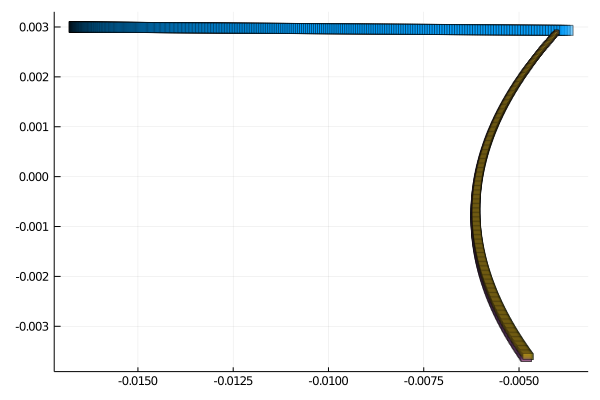

In [155]:
plot(sol[1], vars=(3, 4))
plot!(sol[2], vars=(3, 4))
plot!(sol[3], vars=(3, 4))
plot!(sol[4], vars=(3, 4))
plot!(sol[5], vars=(3, 4))

In [ ]:
# solve first mode
#H = system(ivp);
#S1 = mode(H, 1);
#sol = solve(@ivp(S1, x(0) ∈ X0_GRBX01), tspan = 0 .. 1.0, alg=BOX(δ=1e-3));

In [ ]:
length(sol)

In [ ]:
out = [RA._Projection(set(sol[1], i), (3, 4)) for i in 1:length(sol[1])];
out2 = [RA._Projection(set(sol[2], i), (3, 4)) for i in 1:length(sol[2])];
out3 = [RA._Projection(set(sol[3], i), (3, 4)) for i in 1:length(sol[3])];

In [ ]:
plot(out, xlab="x", ylab="y", color=:blue);
plot!(out2, color=:blue);
plot!(out3, color=:blue)

In [ ]:
stateset(modes(ivp, 1.s))

In [ ]:
stateset(mode(ivp, 1))

In [ ]:
dirs = OctDirections(6)
sol = solve(ivp,
            tspan = 0.0 .. 0.1,
            alg=LGG09(δ=1e-4, template=dirs));

## Reachability settings

### GRBX01

In [ ]:
X0 = (0 .. 0) × (0 .. 0) × (-0.0168 .. -0.0166) × (0.0029 .. 0.0031) × (0 .. 0);

### GRBX02

In [ ]:
X0 = (0 .. 0) × (0 .. 0) × (-0.01675 .. -0.01665) × (0.00285 .. 0.00315) × (0 .. 0);